In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedKFold

In [2]:
data = pd.read_csv('../input/football-hackathon/train_1K0BDt5/train.csv')
test = pd.read_csv('../input/football-hackathon/test_kuhCxHY/test.csv')
sub  = pd.read_csv('../input/football-hackathon/sample_submission_wBWLI0s.csv')

In [3]:
winner = {'winner': 1, 'loser': -1, 'draw': 0}

data['winner'] = data['winner'].map(winner)
test['winner'] = test['winner'].map(winner)

data['team'] = data['team'].map({'team1' : 0, 'team2' : 1})
test['team'] = test['team'].map({'team1' : 0, 'team2' : 1})

data = pd.get_dummies(data, columns = ['competitionId', 'scout_id','team1_system_id', 'team2_system_id', 'player_position_1','player_position_2'])
test = pd.get_dummies(test, columns = ['competitionId', 'scout_id','team1_system_id', 'team2_system_id', 'player_position_1','player_position_2'])

del data['row_id'], test['row_id']

In [4]:
cols = list(set(test.columns.to_list()).intersection(set(data.columns.to_list())))

lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mean_squared_error',
    'nthread':-1,
    'seed' : 16,
}


In [5]:
N_folds = 5
seeds = [455]

data_preds = np.zeros((data.shape[0]))
test_preds = np.zeros((test.shape[0]))

feature_importance = pd.DataFrame()

for seed in seeds:
    print('---------------------------------------')
    print('SEED : ', seed)
    print('---------------------------------------')
    
    
    data['fold'] = -1
    skf = StratifiedKFold(n_splits=N_folds, shuffle=True, random_state=seed)
    for f, (_, idxs) in enumerate(skf.split(data,data['rating_num'].apply(lambda x: int(2*x)))):
        data.loc[idxs, 'fold'] = f
        
    for F in range(N_folds):
        
        print('FOLD : ', F)
        
        train = data[data['fold'] != F].reset_index(drop=True)
        valid = data[data['fold'] == F].reset_index(drop=True)
        
        
        train_dataset = lgb.Dataset(train[cols], train['rating_num'])
        valid_dataset = lgb.Dataset(valid[cols], valid['rating_num'])
        
        model = lgb.train(params = lgb_params,
                          num_boost_round=500,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, valid_dataset], 
                          verbose_eval = 50,
                          early_stopping_rounds=20)
        
        del train_dataset, valid_dataset
        
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = cols
        fold_importance["importance"] = model.feature_importance()
        fold_importance["fold"] = F + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
        
        
        preds = model.predict(valid[cols])
        data_preds[data[data['fold'] == F].index] += preds
        
        preds = model.predict(test[cols])
        test_preds += preds

---------------------------------------
SEED :  455
---------------------------------------
FOLD :  0


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.194927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92941
[LightGBM] [Info] Number of data points in the train set: 16362, number of used features: 859
[LightGBM] [Info] Start training from score 6.887269
Training until validation scores don't improve for 20 rounds
[50]	training's l2: 1.98987	valid_1's l2: 2.51696
[100]	training's l2: 1.47991	valid_1's l2: 2.33727
[150]	training's l2: 1.17178	valid_1's l2: 2.26217
[200]	training's l2: 0.945272	valid_1's l2: 2.22255
[250]	training's l2: 0.760311	valid_1's l2: 2.17099
[300]	training's l2: 0.618472	valid_1's l2: 2.14223
[350]	training's l2: 0.505291	valid_1's l2: 2.11979
[400]	training's l2: 0.415645	valid_1's l2: 2.08722
[450]	training's l2: 0.343061	valid_1's l2: 2.07396
[500]	training's l2: 0.287101	valid_1's l2: 2.06014
Did not meet early stopping. Best iteration is:
[500]	training's l2: 0.28710

In [6]:
data_preds = data_preds / (len(seeds))
test_preds = test_preds / (len(seeds) * N_folds)

In [7]:
r2_score(data['rating_num'], data_preds)

0.38041005661001603

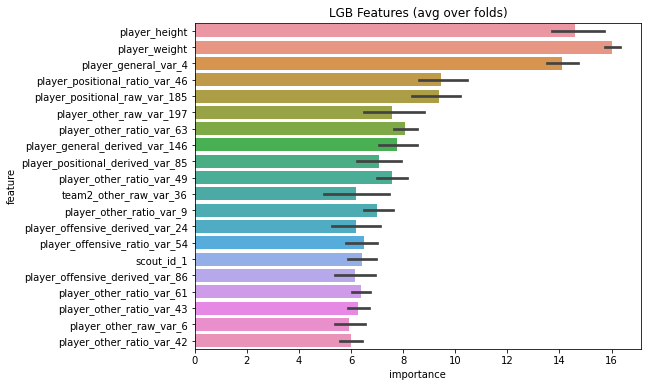

In [8]:
feature_importance["importance"] /= 10
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:20].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(8, 6));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

In [9]:
sub['rating_num'] = test_preds

In [10]:
sub.to_csv('lgb0.csv', index = False)

In [11]:
sub

,row_id,rating_num
0,14785,6.742223
1,15125,5.573677
2,13095,5.830547
3,6079,6.659066
4,16584,6.418781
...,...,...
8769,21259,5.158310
8770,9371,8.385045
8771,23226,6.153844
8772,26623,6.733104
